# Initial Plotting
---
This notebook contains an initial pass at measurement plots for the final chapter of my dissertation.

## Imports and data read-in

### Imports

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress

from IPython.display import Markdown, display
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("colorblind")

### Cell size data

In [3]:
with pd.HDFStore(os.path.join("..", "simulation_measurement_comparison", "simulated_and_measured.h5")) as store:
    cell_size_data = store.data[[
        "diluent",
        "phi_nom",
        "phi",
        "u_phi",
        "dil_mf_nom",
        "dil_mf",
        "u_dil_mf",
        "wave_speed",
        "u_wave_speed", 
        "cell_size_measured",
        "u_cell_size_measured",
        "cell_size_westbrook",
    ]]

cell_size_data.rename({
    "cell_size_measured": "measured",
    "cell_size_westbrook": "simulated",
    "u_cell_size_measured": "u_cell_size",
}, axis=1, inplace=True)
cell_size_data = cell_size_data.melt(
    id_vars=[
        "diluent",
        "phi_nom",
        "phi",
        "u_phi",
        "dil_mf_nom",
        "dil_mf",
        "u_dil_mf",
        "wave_speed",
        "u_wave_speed",
        "u_cell_size",
    ],
    value_vars=["measured", "simulated"],
    var_name="method",
    value_name="cell_size",
)
cell_size_data.loc[cell_size_data["method"] == "simulated", "u_cell_size"] = np.NaN

cell_size_data.head()

,diluent,phi_nom,phi,u_phi,dil_mf_nom,dil_mf,u_dil_mf,wave_speed,u_wave_speed,u_cell_size,method,cell_size
0,CO2,0.4,0.419182,0.000208,0.10,0.103943,0.000040,1780.064483,1.212763,0.480062,measured,17.711596
1,CO2,0.4,0.416662,0.000215,0.15,0.154795,0.000036,1742.324854,1.161985,0.479481,measured,26.122865
2,CO2,0.4,0.425508,0.000378,0.20,0.207642,0.000063,1680.937965,1.326527,0.594380,measured,45.265852
3,CO2,0.7,0.735369,0.000243,0.10,0.104023,0.000045,1944.385714,1.446872,0.530100,measured,11.744907
4,CO2,0.7,0.730354,0.000250,0.15,0.154600,0.000045,1884.805654,1.665023,0.512883,measured,14.199823


### Wave speed data

In [4]:
speed_data = pd.read_csv(os.path.join("..", "cj_study", "cj_tad_ss_results.csv"))[[
    "fuel", 
    "oxidizer",
    "diluent",
    "phi_nom",
    "phi",
    "u_phi",
    "dil_mf_nom",
    "dil_mf",
    "u_dil_mf",
    "wave_speed",
    "u_wave_speed", 
    "cj_speed",
    "sound_speed",
    "t_ad",
]]

# Filter out unsuccessful detonations
speed_data = speed_data[
    (speed_data["cj_speed"].notna())
    & (speed_data["sound_speed"].notna())
    & (speed_data["wave_speed"].notna())
]

# Ignore propane/air data
speed_data = speed_data[speed_data["fuel"] == "CH4"]

speed_data.head()

,fuel,oxidizer,diluent,phi_nom,phi,u_phi,dil_mf_nom,dil_mf,u_dil_mf,wave_speed,u_wave_speed,cj_speed,sound_speed,t_ad
0,CH4,N2O,N2,1.0,1.070145,0.000710,0.10,0.232712,0.000099,2059.459459,2.811308,2114.464151,1148.785328,2794.637781
1,CH4,N2O,N2,0.4,0.412540,0.000307,0.15,0.250255,0.000054,1795.959596,2.137938,1895.341221,1041.095726,2436.412954
2,CH4,N2O,N2,1.0,1.088798,0.000911,0.20,0.387742,0.000101,1961.029412,2.549002,2031.781270,1108.463881,2657.521685
3,CH4,N2O,CO2,0.4,0.413831,0.000259,0.10,0.102603,0.000052,1783.946488,2.109433,1875.787281,1021.580802,2516.543411
4,CH4,N2O,N2,1.0,1.095292,0.000808,0.20,0.386997,0.000086,1979.220779,2.596513,2033.211722,1109.304497,2658.704224


## Measured vs. simulated cell sizes

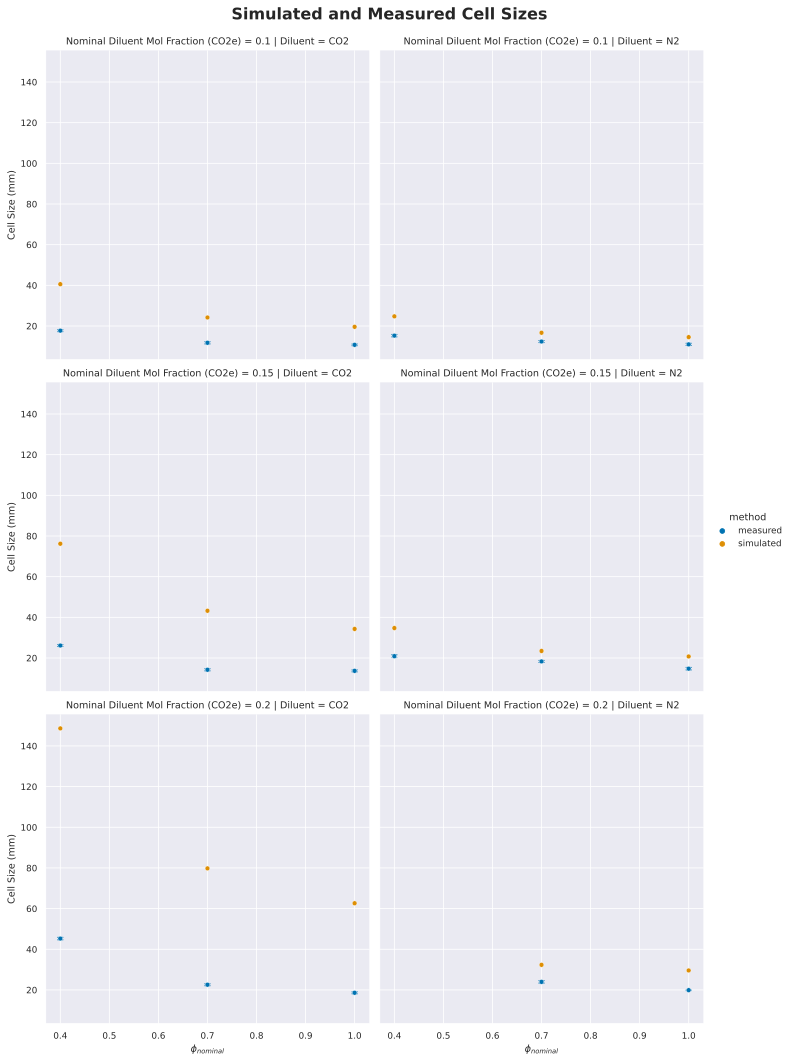

In [5]:
cell_size_plots = sns.relplot(
    x="phi_nom",
    y="cell_size",
    row="dil_mf_nom",
    col="diluent",
    hue="method",
    data=cell_size_data,
)
cell_size_plots.fig.subplots_adjust(top=0.94)
cell_size_plots.fig.suptitle("Simulated and Measured Cell Sizes", weight="bold", size=16)
legend_updated = False
for ax in cell_size_plots.axes.flatten():
    ax.set_ylabel("Cell Size (mm)")
    if ax.get_xlabel() is not None:
        ax.set_xlabel("$\phi_{nominal}$")
    title = ax.get_title()
    parts = title.split(" | ")
    dil_mf_nom = float(parts[0].split(" = ")[1])
    diluent = parts[1].split(" = ")[1]
    sub_df = cell_size_data[(cell_size_data["dil_mf_nom"] == dil_mf_nom) & (cell_size_data["diluent"] == diluent)]
    err = ax.errorbar(
        x=sub_df["phi_nom"], 
        y=sub_df["cell_size"],
        yerr=sub_df["u_cell_size"],
        c="C0",
        ls="None",
        zorder=-1,
        capsize=3,
        marker=None,
    )
    ax.set_title(title.replace("dil_mf_nom", "Nominal Diluent Mol Fraction (CO2e)").replace("diluent", "Diluent"))
    
plt.savefig("cell_sizes.pdf", format="pdf")

Meeting tests -- 2023-06-08

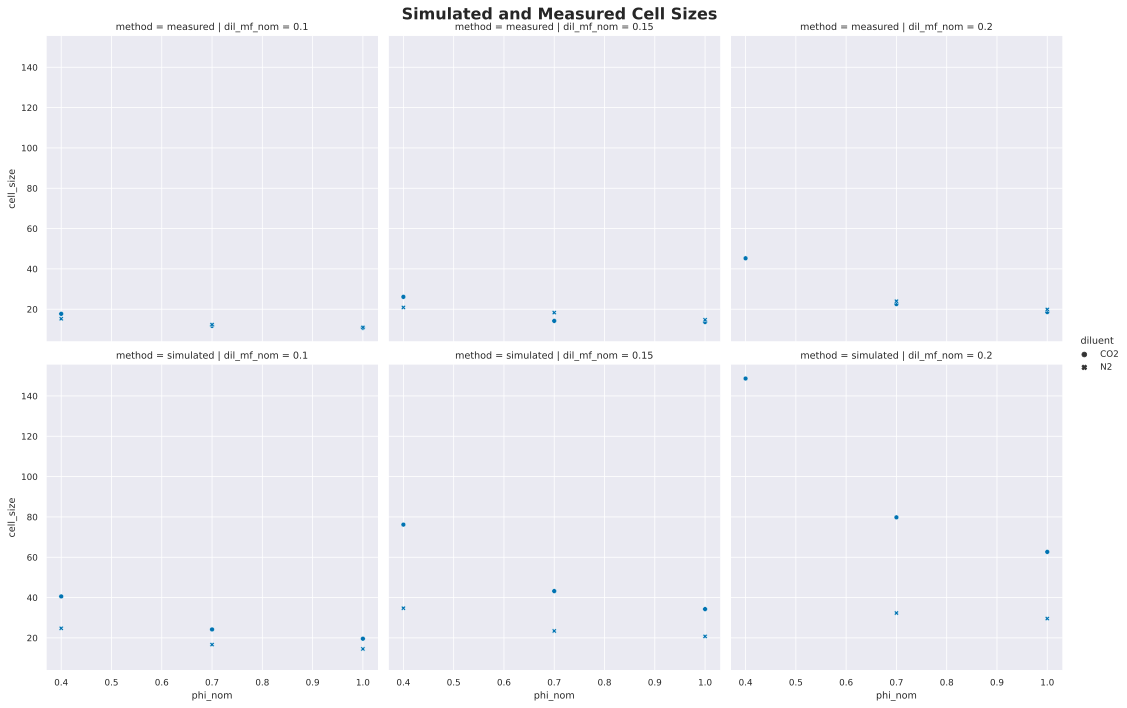

In [6]:
cell_size_plots = sns.relplot(
    x="phi_nom",
    y="cell_size",
    col="dil_mf_nom",
    style="diluent",
    row="method",
    data=cell_size_data,
)
cell_size_plots.fig.subplots_adjust(top=0.94)
cell_size_plots.fig.suptitle("Simulated and Measured Cell Sizes", weight="bold", size=16)
legend_updated = False
# for ax in cell_size_plots.axes.flatten():
#     ax.set_ylabel("Cell Size (mm)")
#     if ax.get_xlabel() is not None:
#         ax.set_xlabel("$\phi_{nominal}$")
#     title = ax.get_title()
#     parts = title.split(" | ")
#     dil_mf_nom = float(parts[0].split(" = ")[1])
#     diluent = parts[1].split(" = ")[1]
#     sub_df = cell_size_data[(cell_size_data["dil_mf_nom"] == dil_mf_nom) & (cell_size_data["diluent"] == diluent)]
#     err = ax.errorbar(
#         x=sub_df["phi_nom"], 
#         y=sub_df["cell_size"],
#         yerr=sub_df["u_cell_size"],
#         c="C0",
#         ls="None",
#         zorder=-1,
#         capsize=3,
#         marker=None,
#     )
#     ax.set_title(title.replace("dil_mf_nom", "Nominal Diluent Mol Fraction (CO2e)").replace("diluent", "Diluent"))
    
# plt.savefig("cell_sizes.pdf", format="pdf")

TODO: break this out and look at overlap between measured CO2 and N2 only

In [8]:
cell_size_plots = sns.relplot(
    x="phi_nom",
    y="cell_size",
    col="dil_mf_nom",
    style="diluent",
    data=cell_size_data[cell_size_data["method"=="measured"]],
)
cell_size_plots.fig.subplots_adjust(top=0.94)
cell_size_plots.fig.suptitle("Simulated and Measured Cell Sizes", weight="bold", size=16)

KeyError: False

## Measured wave speeds vs. diluent mole fraction

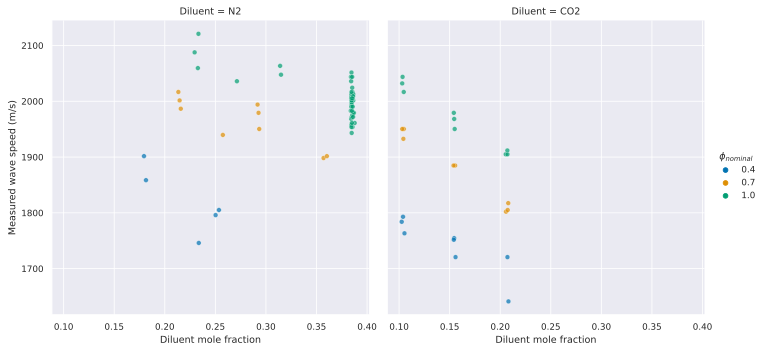

In [11]:
measured_speed_plots = sns.relplot(
    x="dil_mf",
    y="wave_speed",
    hue="phi_nom",
    col="diluent",
    data=speed_data,
    alpha=0.7,
    palette="colorblind",  # I shouldn't have to set this here, but I do
)
measured_speed_plots.set_xlabels("Diluent mole fraction")
measured_speed_plots.set_ylabels("Measured wave speed (m/s)")
measured_speed_plots._legend.set_title("$\phi_{nominal}$")
for ax in measured_speed_plots.axes.flatten():
    ax.set_title(ax.get_title().replace("diluent", "Diluent"))
    
plt.savefig("wave_speeds.pdf", format="pdf")

Meeting tests -- 2022-06-08

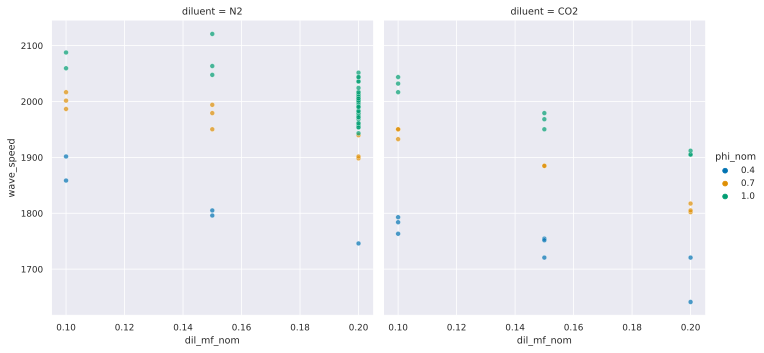

In [12]:
measured_speed_plots = sns.relplot(
    x="dil_mf_nom",
    y="wave_speed",
    hue="phi_nom",
    col="diluent",
    data=speed_data,
    alpha=0.7,
    palette="colorblind",  # I shouldn't have to set this here, but I do
)

TODO: do curve fits here and compare with normalized -- compare with sound speed results

---

1. Show unchanged mole fraction vs measured speed (CO2, N2 side by side)
2. what causes the difference?
3. Normalize by AFT (this plot) -- still different. What else could it be?
4. Normalize by SS (below) -- now it's roughly constant. neat.
5. Normalize by CJ (not shown yet) -- this accounts for reactions but not rates

* there _is_ a sensitivity of n2 vs co2 (for speed)
* chemistry matters, but rxn rates don't seem to
* for the purposes of matching behavior, sound speed is more important than AFT


* we see a speed sensitivity but _not_ a cell size sensitivity
* we see a sensitivity in the calculated results that is not borne out by our experiments
  * this suggests a breakdown somewhere in the simulations or underlying assumptions
  * open question: what is causing that false sensitivity? (this is what we're beginning to address here)

---

DB todo: how does this compare to what we'd expect from literature?

## Normalized wave speeds vs. diluent mole fraction

|          |      slope |   intercept |     R$^{2}$ |
|:---------|-----------:|------------:|------------:|
| CO2      | -0.0118113 |     1.78641 | 0.000267179 |
| N2       | -0.017157  |     1.80754 | 0.0010854   |
| Combined |  0.0554694 |     1.78072 | 0.028889    |

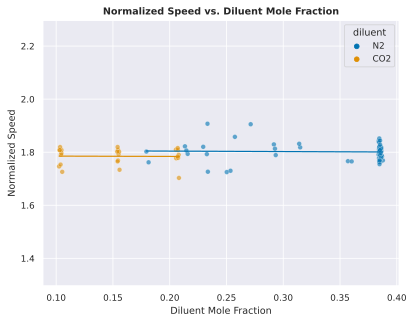

In [15]:
# use dil_mf or dil_mf_nom everywhere
mol_frac = "dil_mf"

# Normalize
speed_data["normalized"] = speed_data["wave_speed"] / speed_data["sound_speed"]

sns.scatterplot(
    x=mol_frac,
    y="normalized",
    hue ="diluent",
    data=speed_data,
    alpha=0.6
)

# Perform regressions
n2_data = speed_data[speed_data["diluent"] == "N2"]
co2_data = speed_data[speed_data["diluent"] == "CO2"]
n2_regression = linregress(n2_data[mol_frac], n2_data["normalized"])
co2_regression = linregress(co2_data[mol_frac], co2_data["normalized"])
total_regression = linregress(speed_data[mol_frac], speed_data["normalized"])

# x = np.array([speed_data[mol_frac].min(), speed_data[mol_frac].max()])
# plt.plot(x, total_regression.slope * x + total_regression.intercept, "k--", alpha=0.5)

for i, (regression, data) in enumerate(zip([n2_regression, co2_regression], [n2_data, co2_data])):
    x = np.array([data[mol_frac].min(), data[mol_frac].max()])
    plt.plot(x, regression.slope * x + regression.intercept, f"C{i}")

plot_center = speed_data["normalized"].mean()
window_height = 1
plt.ylim(plot_center - window_height / 2, plot_center + window_height / 2)
plt.title("Normalized Speed vs. Diluent Mole Fraction", weight="bold")
plt.xlabel("Diluent Mole Fraction")
plt.ylabel("Normalized Speed");

regression_summary = pd.DataFrame({
    "CO2": {"slope": co2_regression.slope, "intercept": co2_regression.intercept, "R$^{2}$": co2_regression.rvalue**2},
    "N2": {"slope": n2_regression.slope, "intercept": n2_regression.intercept, "R$^{2}$": n2_regression.rvalue**2},
    "Combined": {"slope": total_regression.slope, "intercept": total_regression.intercept, "R$^{2}$": total_regression.rvalue**2},
})

plt.savefig("wave_speeds_normalized.pdf", format="pdf")

display(Markdown(regression_summary.T.to_markdown()))

todo: plot this with CO2 normalized dil mf

<Axes: xlabel='dil_mf_nom', ylabel='normalized'>

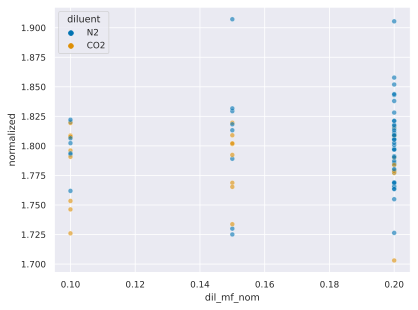

In [16]:
sns.scatterplot(
    x="dil_mf_nom",
    y="normalized",
    hue ="diluent",
    data=speed_data,
    alpha=0.6
)